<a href="https://colab.research.google.com/github/muhafidz-ahmad/sentiment-analysis-of-indonesian-tweet/blob/main/Hate_Speech_Twitter.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Packages Preparation

In [1]:
!pip install Sastrawi
!pip install wordcloud==1.8.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.7/209.7 KB 5.3 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.6/363.6 KB 7.9 MB/s eta 0:00:00
  Attempting uninstall: wordcloud
    Found existing installation: wordcloud 1.8.2.2
    Uninstalling wordcloud-1.8.2.2:
      Successfully uninstalled wordcloud-1.8.2.2


In [2]:
import string
import re
import pathlib
import json
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

from wordcloud import WordCloud, STOPWORDS

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_theme(style="whitegrid")

from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, regularizers, layers, optimizers, losses, initializers
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


# Import Data

https://www.kaggle.com/datasets/ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text

In [3]:
from google.colab import files
files.upload()

!rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d ilhamfp31/indonesian-abusive-and-hate-speech-twitter-text
!unzip /content/indonesian-abusive-and-hate-speech-twitter-text.zip -d /content/

Saving kaggle.json to kaggle.json
rm: cannot remove '/root/.kaggle': No such file or directory
  0% 0.00/814k [00:00<?, ?B/s]
100% 814k/814k [00:00<00:00, 86.5MB/s]
Archive:  /content/indonesian-abusive-and-hate-speech-twitter-text.zip
  inflating: /content/README.md      
  inflating: /content/abusive.csv    
  inflating: /content/citation.bib   
  inflating: /content/data.csv       
  inflating: /content/new_kamusalay.csv  


# Data Preparation

In [4]:
df = pd.read_csv('/content/data.csv', encoding='latin-1')
df.head()

,Tweet,HS,Abusive,HS_Individual,HS_Group,HS_Religion,HS_Race,HS_Physical,HS_Gender,HS_Other,HS_Weak,HS_Moderate,HS_Strong
0,- disaat semua cowok berusaha melacak perhatia...,1,1,1,0,0,0,0,0,1,1,0,0
1,RT USER: USER siapa yang telat ngasih tau elu?...,0,1,0,0,0,0,0,0,0,0,0,0
2,"41. Kadang aku berfikir, kenapa aku tetap perc...",0,0,0,0,0,0,0,0,0,0,0,0
3,USER USER AKU ITU AKU\n\nKU TAU MATAMU SIPIT T...,0,0,0,0,0,0,0,0,0,0,0,0
4,USER USER Kaum cebong kapir udah keliatan dong...,1,1,0,1,1,0,0,0,0,0,1,0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13169 entries, 0 to 13168
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet          13169 non-null  object
 1   HS             13169 non-null  int64 
 2   Abusive        13169 non-null  int64 
 3   HS_Individual  13169 non-null  int64 
 4   HS_Group       13169 non-null  int64 
 5   HS_Religion    13169 non-null  int64 
 6   HS_Race        13169 non-null  int64 
 7   HS_Physical    13169 non-null  int64 
 8   HS_Gender      13169 non-null  int64 
 9   HS_Other       13169 non-null  int64 
 10  HS_Weak        13169 non-null  int64 
 11  HS_Moderate    13169 non-null  int64 
 12  HS_Strong      13169 non-null  int64 
dtypes: int64(12), object(1)
memory usage: 1.3+ MB


# Data Cleansing

## Duplicated Data

Jumlah data yang duplikat.

In [6]:
duplicated_row = df.duplicated(subset=['Tweet'])
duplicated_row.sum()

146

Hapus data duplikat yang duplikat.

In [7]:
df.drop_duplicates(subset=['Tweet'], inplace=True)
df.shape

(13023, 13)

In [8]:
print('Jumlah missing value (null)')
print(df.isnull().sum())

Jumlah missing value (null)
Tweet            0
HS               0
Abusive          0
HS_Individual    0
HS_Group         0
HS_Religion      0
HS_Race          0
HS_Physical      0
HS_Gender        0
HS_Other         0
HS_Weak          0
HS_Moderate      0
HS_Strong        0
dtype: int64


# Data Preprocessing

Terdapat 5 tahap preprocessing yang dilakukan pada data teks disini, yaitu:
1. case folding
2. menghapus karakter yang tidak penting (URL, username, dll)
3. menghapus tanda baca
4. menghapus stopword
5. mengubah kata-kata alay menjadi lebih dapat dibaca

In [9]:
alay_df = pd.read_csv('/content/new_kamusalay.csv', 
                        encoding = 'latin-1', 
                        header = None)

alay_df.rename(columns={0: 'original', 
                        1: 'replacement'},
               inplace = True)

alay_dict_map = dict(zip(alay_df['original'], alay_df['replacement']))

def normalize_alay(text):
    return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

In [10]:
def convert_lower_case(text):
  return text.lower()

def remove_stop_words(text):
  stop_words = stopwords.words('indonesian')
  words = word_tokenize(str(text))
  new_text = ""
  for w in words:
    if w not in stop_words and len(w) > 1:
      new_text = new_text + " " + w
  return new_text

def remove_unnecessary_char(text):
  text = re.sub('\n',' ',text) # Remove every '\n'
  text = re.sub('rt',' ',text) # Remove every retweet symbol
  text = re.sub('user',' ',text) # Remove every username
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
  text = re.sub('  +', ' ', text) # Remove extra spaces
  
  text = re.sub('x9f', ' ', text)
  text = re.sub('x98', ' ', text)
  text = re.sub('xf0', ' ', text)

  text = re.sub(' ya ', ' ', text)
  text = re.sub('x82', ' ', text)
  text = re.sub('uniform', ' ', text)
  text = re.sub('resource', ' ', text)

  text = re.sub('xe2', ' ', text)
  text = re.sub('x80', ' ', text)
  text = re.sub('x91', ' ', text)
  text = re.sub('x8c', ' ', text)

  text = re.sub('locator', ' ', text)
  return text

def remove_punctuation(text):
  symbols = string.punctuation
  for i in range(len(symbols)):
    text = text.replace(symbols[i], ' ')
    text = text.replace("  ", " ")
  text = text.replace(',', '')
  return text

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  
  tokens = word_tokenize(str(text))
  new_text = ""
  for w in tokens:
    new_text = new_text + " " + stemmer.stem(w)
  return new_text

counter = 0

def preprocess(text, verbose=0):
  global counter

  text = convert_lower_case(text)
  text = remove_unnecessary_char(text)
  text = remove_punctuation(text)
  text = remove_stop_words(text)
  text = normalize_alay(text)
  # text = stemming(text)
  text = remove_stop_words(text)
  text = remove_punctuation(text)

  counter += 1
  if (counter % 10 == 0) and (verbose == 1):
    print(f"\r{counter}", end="")
  return text

df_clean = df.copy()

df_clean['Tweet'] = df.apply(lambda x: preprocess(x['Tweet'], verbose=1),
                             axis=1)

print()
print(df_clean['Tweet'].iloc[45])

13020
 ciptakan situasi keamanan ketertiban masyarakat menjelang pilihan kepala daerah 2018 kepala kepolisian sektor konang silaturahmi tokoh masyarakat


# Exploratory Data Analysis

## Hate Speech

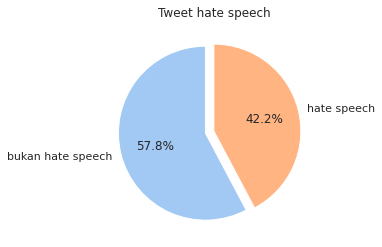

In [ ]:
hs = df_clean['HS'].value_counts()
hs.rename(index={0: "bukan hate speech",
                 1: "hate speech"},
          inplace=True)

colors = sns.color_palette('pastel')[0:5]

plt.pie(hs.values,
        labels = hs.index,
        colors = colors,
        autopct = '%1.1f%%',
        startangle = 90,
        explode = (0.1, 0))
plt.title('Tweet hate speech')
plt.show()

Text(0.5, 1.0, 'Kategori hate speech')

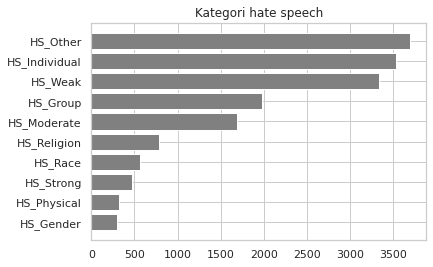

In [ ]:
hs_category = df.iloc[:, 3:].sum()

plt.barh(y = hs_category.sort_values().index,
         width = hs_category.sort_values().values,
         color = 'grey')
plt.title("Kategori hate speech")

### Word Freq

Gabungkan semua teks tiap kategori hate speech

In [ ]:
hscat_text = dict()

for label in df_clean.columns[3:]:
  joined_text = str()
  for tweet in df_clean.loc[df_clean[label]==1]['Tweet']:
    joined_text += preprocess(tweet)
  hscat_text[label] = joined_text

Generate wordcloud

In [ ]:
wc_dict = dict()

for label in hscat_text:
  wc_dict[label] = WordCloud(
      background_color='white',
      max_words=2000
  )
  
  wc_dict[label].generate(hscat_text[label])

Visualisasi wordcloud

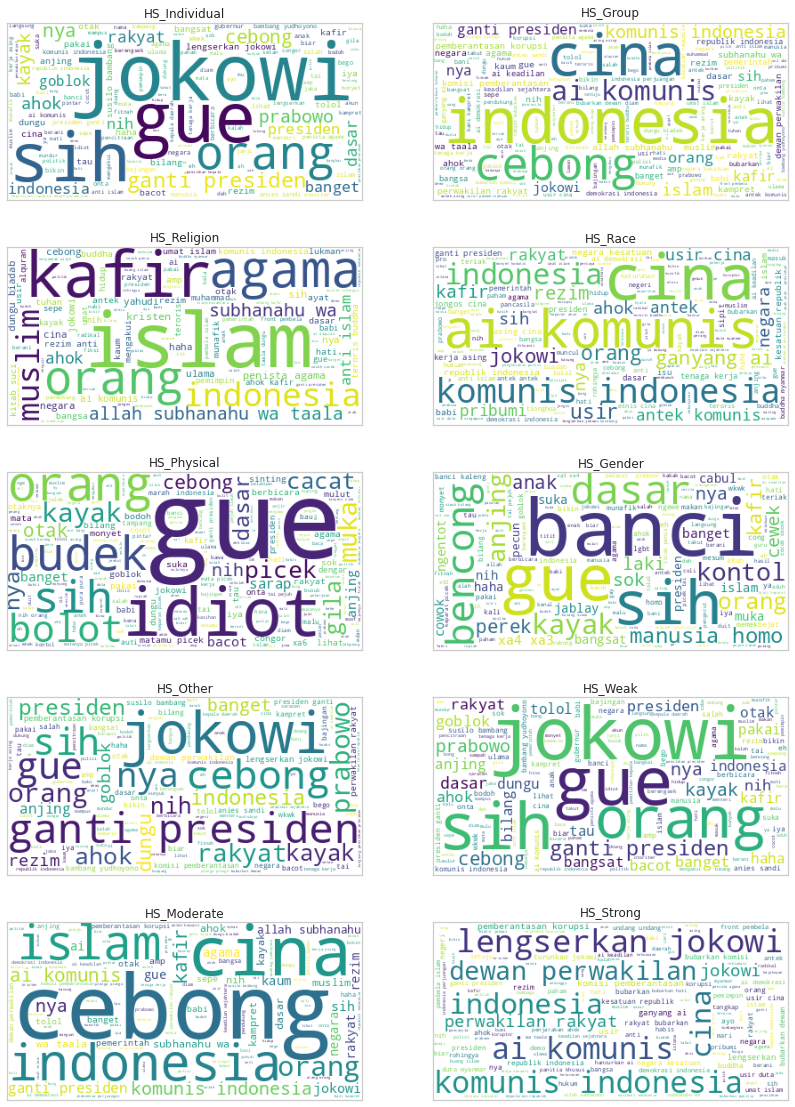

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(14,20))

for i, label in enumerate(df_clean.columns[3:]):
  row = int(i/2)
  col = i % 2

  ax[row, col].imshow(wc_dict[label])
  ax[row, col].set_title(label)
  ax[row, col].set_xticks([])
  ax[row, col].set_yticks([])

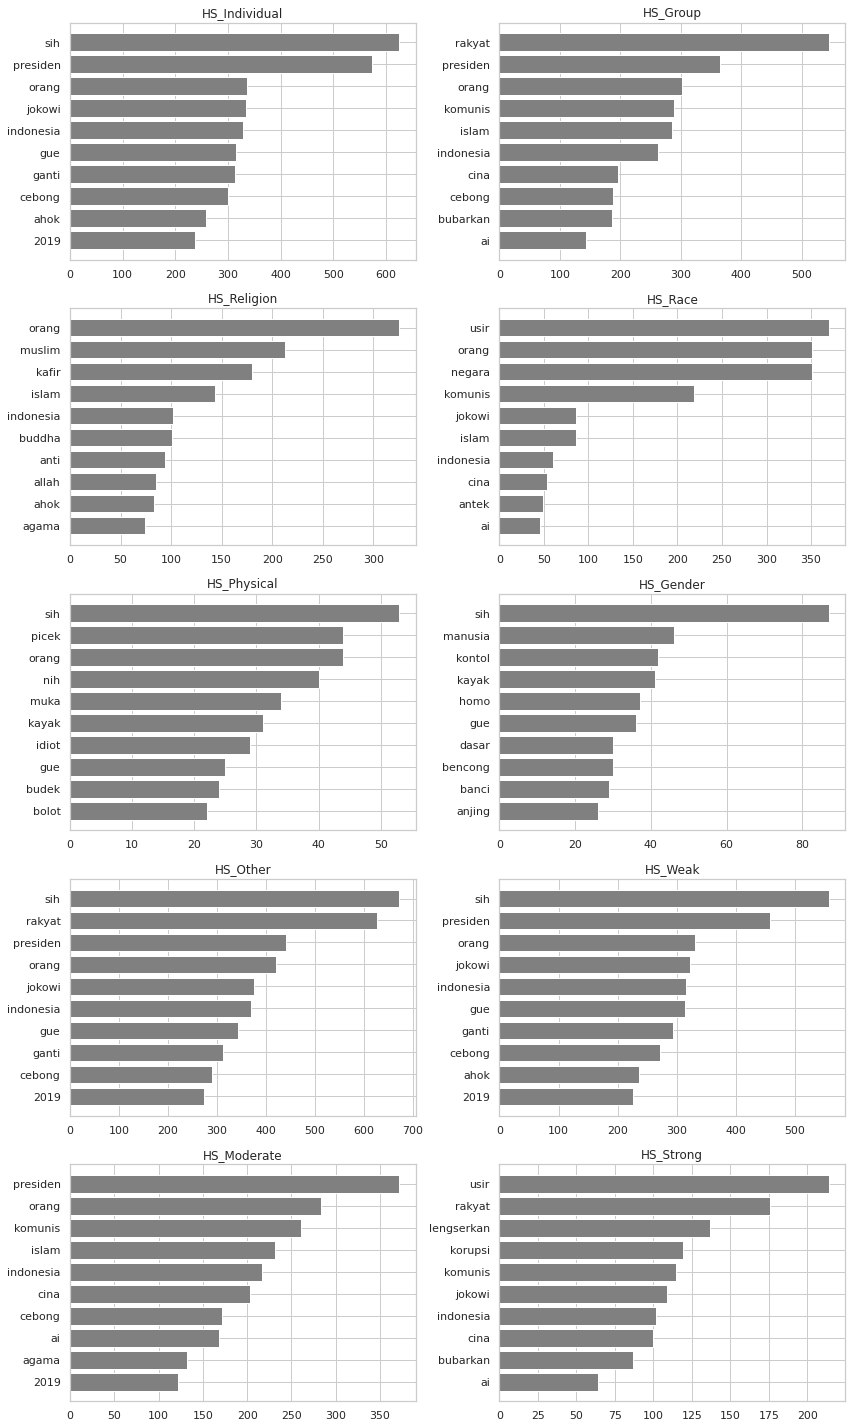

In [ ]:
fig, ax = plt.subplots(5, 2, figsize=(12,20))

for i, label in enumerate(hscat_text):
  freq_dist = nltk.FreqDist(nltk.tokenize.word_tokenize(hscat_text[label]))
  
  df_cat = pd.DataFrame(list(freq_dist.items()), columns=["Kata", "Frekuensi"])
  df_cat = df_cat.sort_values(by=["Frekuensi"], ascending=False).head(10)

  row = int(i/2)
  col = i % 2

  ax[row, col].barh(y = sorted(df_cat['Kata']),
                    width = sorted(df_cat['Frekuensi']),
                    color = 'grey')
  ax[row, col].set_title(label)

plt.tight_layout()

## Not Hate Speech

### Word Freq

Gabungkat text antara teks hate speech dan teks bukan hate speech

In [ ]:
hscat_text = dict()

for label in [0, 1]:
  joined_text = str()
  for tweet in df_clean.loc[df_clean['HS']==label]['Tweet']:
    joined_text += preprocess(tweet)
  if label == 0:
    label = "Not HS"
  else:
    label = "HS"
  hscat_text[label] = joined_text

Generate word cloud

In [ ]:
wc_dict = dict()

for label in hscat_text:
  wc_dict[label] = WordCloud(
      background_color='white',
      max_words=2000
  )
  
  wc_dict[label].generate(hscat_text[label])

Visualisasi word cloud

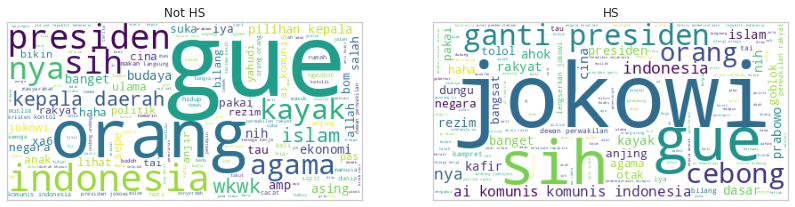

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,14))

for i, label in enumerate(hscat_text):
  ax[i].imshow(wc_dict[label])
  ax[i].set_title(label)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

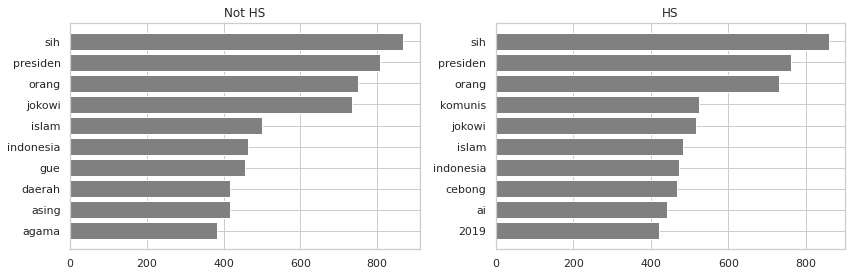

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(12,4))

for i, label in enumerate(hscat_text):
  freq_dist = nltk.FreqDist(nltk.tokenize.word_tokenize(hscat_text[label]))
  df_cat = pd.DataFrame(list(freq_dist.items()), columns=["Kata", "Frekuensi"])
  df_cat = df_cat.sort_values(by=["Frekuensi"], ascending=False).head(10)

  ax[i].barh(y = sorted(df_cat['Kata']),
             width = sorted(df_cat['Frekuensi']),
             color = 'grey')
  ax[i].set_title(label)

plt.tight_layout()

## Abusive

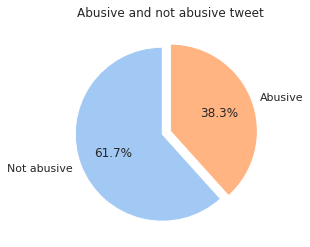

In [ ]:
abusive = df_clean['Abusive'].value_counts()
abusive.rename(index={0: "Not abusive",
                      1: "Abusive"},
               inplace=True)

plt.pie(abusive.values,
        labels = abusive.index,
        colors = colors,
        autopct = '%1.1f%%',
        startangle = 90,
        explode = (0.1, 0))
plt.title('Abusive and not abusive tweet')
plt.show()

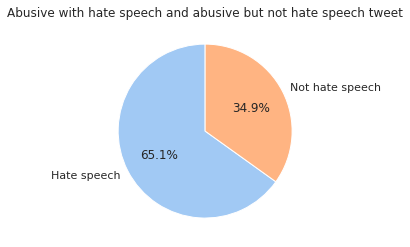

In [ ]:
abusive = df_clean[df_clean['Abusive'] == 1]['HS'].value_counts()
abusive.rename(index={0: "Not hate speech",
                      1: "Hate speech"},
               inplace=True)

plt.pie(abusive.values,
        labels = abusive.index,
        colors = colors,
        autopct = '%1.1f%%',
        startangle = 90)
plt.title('Abusive with hate speech and abusive but not hate speech tweet')
plt.show()

Text(0.5, 1.0, 'Abusive tweet')

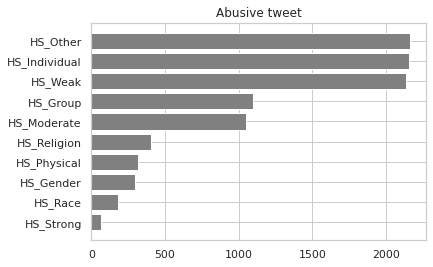

In [ ]:
abusive = df_clean[df_clean['Abusive'] == 1].iloc[:, 1:].sum().drop(['Abusive', 
                                                                     'HS'])
plt.barh(y = abusive.sort_values().index,
         width = abusive.sort_values().values,
         color = 'grey')
plt.title('Abusive tweet')

### Word Freq

Gabungkan teks

In [ ]:
abusive_text = dict()

for label in [0, 1]:
  joined_text = str()
  for tweet in df_clean.loc[df_clean['Abusive']==label]['Tweet']:
    joined_text += preprocess(tweet)
  if label == 0:
    label = "Not Abusive"
  else:
    label = "Abusive"
  abusive_text[label] = joined_text

Generate word cloud

In [ ]:
wc_dict = dict()

for label in abusive_text:
  wc_dict[label] = WordCloud(
      background_color='white',
      max_words=2000
  )
  
  wc_dict[label].generate(abusive_text[label])

Visualisasi Word Cloud

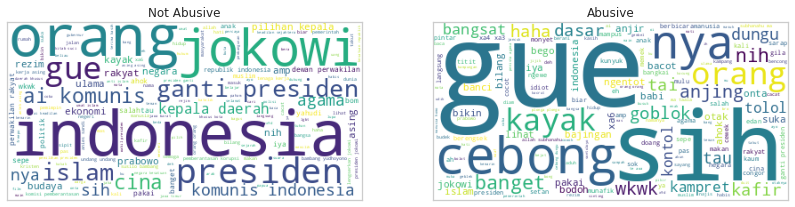

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,14))

for i, label in enumerate(abusive_text):
  ax[i].imshow(wc_dict[label])
  ax[i].set_title(label)
  ax[i].set_xticks([])
  ax[i].set_yticks([])

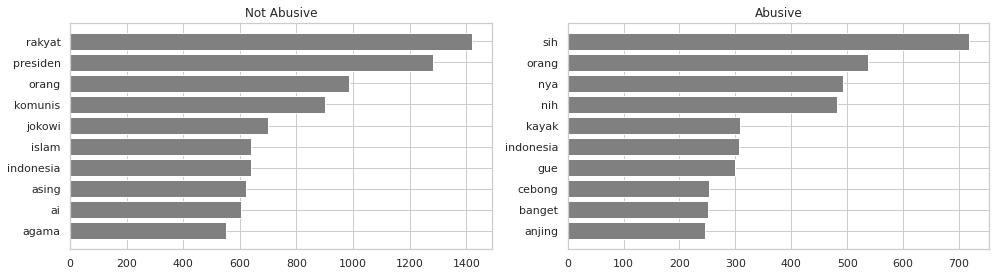

In [ ]:
fig, ax = plt.subplots(1, 2, figsize=(14,4))

for i, label in enumerate(abusive_text):
  freq_dist = nltk.FreqDist(nltk.tokenize.word_tokenize(abusive_text[label]))

  df_cat = pd.DataFrame(list(freq_dist.items()), columns=["Kata", "Frekuensi"])
  df_cat = df_cat.sort_values(by=["Frekuensi"], ascending=False).head(10)

  ax[i].barh(y = sorted(df_cat['Kata']),
             width = sorted(df_cat['Frekuensi']),
             color = 'grey')
  ax[i].set_title(label)

plt.tight_layout()

## Correlation

(array([0.5, 1.5, 2.5, 3.5, 4.5, 5.5, 6.5, 7.5, 8.5]),
 [Text(0.5, 0, 'HS_Individual'),
  Text(1.5, 0, 'HS_Group'),
  Text(2.5, 0, 'HS_Religion'),
  Text(3.5, 0, 'HS_Race'),
  Text(4.5, 0, 'HS_Physical'),
  Text(5.5, 0, 'HS_Gender'),
  Text(6.5, 0, 'HS_Weak'),
  Text(7.5, 0, 'HS_Moderate'),
  Text(8.5, 0, 'HS_Strong')])

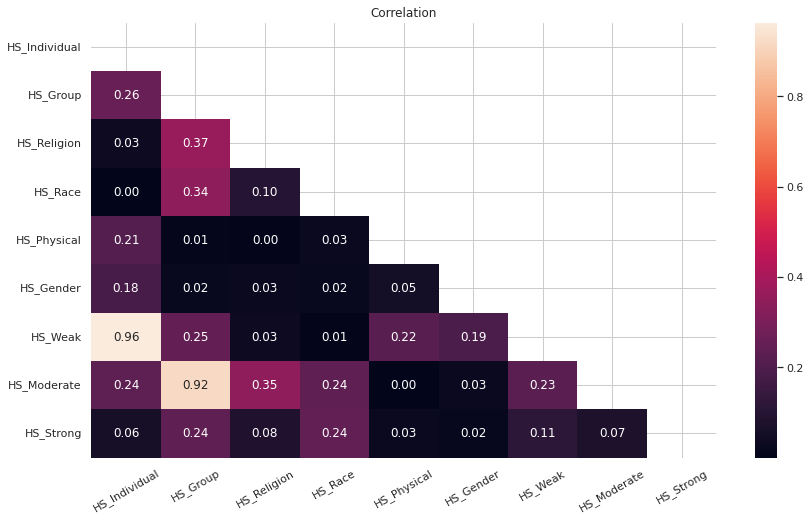

In [ ]:
corr = df_clean.drop(['Tweet', 'HS', 'Abusive', 'HS_Other'],
                     axis=1).corr().abs()
mask = np.triu(corr)

plt.figure(figsize=(14,8))
sns.heatmap(corr, annot=True, mask=mask, fmt='.2f')
plt.title("Correlation")
plt.xticks(rotation=30)

# Sentiment Analysis

## Label Preparation

In [11]:
df_sentiment = df_clean.copy().drop(df_clean.columns[3:],
                                    axis = 1)

def sentiment(hs, abusive):
  if (hs == 1) and (abusive == 1):
    return 'HS_Abusive'
  elif (hs == 1) and (abusive == 0):
    return 'HS_NotAbusive'
  elif (hs == 0) and (abusive == 1):
    return 'NotHS_Abusive'
  else:
    return 'NotHS_NotAbusive'

df_sentiment['sentiment'] = df_sentiment.apply(lambda x: sentiment(x['HS'],
                                                                   x['Abusive']),
                                               axis=1)

df_sentiment.drop(['HS', 'Abusive'], axis=1, inplace=True)

df_sentiment.head()

,Tweet,sentiment
0,cowok berusaha melacak perhatian gue lantas r...,HS_Abusive
1,telat tau edan sarap gue bergaul cigax jifla ...,NotHS_Abusive
2,41 kadang berpikir percaya tuhan jatuh berkal...,NotHS_NotAbusive
3,ku tau matamu sipit,NotHS_NotAbusive
4,kaum cebong kafir dongoknya dungu haha,HS_Abusive


In [12]:
df_label = pd.get_dummies(df_sentiment['sentiment'])
df_sentiment.drop('sentiment', axis=1, inplace=True)
df_sentiment = pd.concat([df_sentiment['Tweet'], df_label], axis=1)

df_sentiment.head()

,Tweet,HS_Abusive,HS_NotAbusive,NotHS_Abusive,NotHS_NotAbusive
0,cowok berusaha melacak perhatian gue lantas r...,1,0,0,0
1,telat tau edan sarap gue bergaul cigax jifla ...,0,0,1,0
2,41 kadang berpikir percaya tuhan jatuh berkal...,0,0,0,1
3,ku tau matamu sipit,0,0,0,1
4,kaum cebong kafir dongoknya dungu haha,1,0,0,0


<Axes: title={'center': 'Jumlah tweet tiap kategori'}>

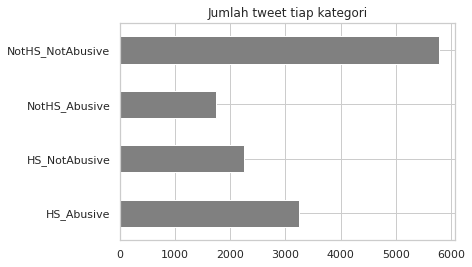

In [13]:
df_sentiment.sum()[1:].plot(kind='barh', color='grey',
                            title='Jumlah tweet tiap kategori')

In [14]:
tweet = df_sentiment['Tweet'].values
labels = df_sentiment.iloc[:, 1:].values

print(">>> Teks:")
print(tweet[:2])
print()
print(">>> Label:")
print(labels[:2])

>>> Teks:
[' cowok berusaha melacak perhatian gue lantas remehkan perhatian gue kasih khusus basic cowok bego'
 ' telat tau edan sarap gue bergaul cigax jifla calis licew']

>>> Label:
[[1 0 0 0]
 [0 0 1 0]]


In [15]:
labels_list = df_sentiment.columns[1:]
labels_list

Index(['HS_Abusive', 'HS_NotAbusive', 'NotHS_Abusive', 'NotHS_NotAbusive'], dtype='object')

## Data Splitting

In [16]:
x_train, x_val, y_train, y_val = train_test_split(tweet,
                                                  labels,
                                                  test_size=0.3,
                                                  random_state=45)

x_val, x_test, y_val, y_test = train_test_split(x_val, y_val,
                                                test_size=0.5,
                                                random_state=53)

## Tokenizing

Mengubah data teks yang awalnya berbentuk kalimat menjadi pecahan kata-kata atau token-token.

* Maksimal kosakata yang diambil untuk tokenizing adalah sebanyak 15000 berdasarkan kata yang paling sering muncul.
* Maksimal panjang array dalam satu data diatur sebanyak 1000.
* Jika jumlah kata dalam suatu data kurang dari 1000 kata, maka dalam array hasil tokenisasi, sisa nilai diakhirnya akan diatur menjadi 0.

In [17]:
NUM_WORDS = 10000

tokenizer = Tokenizer(num_words=NUM_WORDS, oov_token='')

tokenizer.fit_on_texts(x_train)

seq_train = tokenizer.texts_to_sequences(x_train)
seq_val = tokenizer.texts_to_sequences(x_val)
seq_test = tokenizer.texts_to_sequences(x_test)

x_train = pad_sequences(seq_train, padding='post',
                        maxlen=1000, truncating='post')
x_val = pad_sequences(seq_val, padding='post', 
                      maxlen=1000, truncating='post')
x_test = pad_sequences(seq_test, padding='post', 
                       maxlen=1000, truncating='post')

print(len(tokenizer.word_index))
print(x_train.max())
print(len(x_val[0]))

16209
9999
1000


Simpan tokenizer

In [28]:
with open('/content/drive/MyDrive/Colab Notebooks/Data Science Trainee JSC/tokenizer.pickle',
          'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Modelling

Model yang akan digunakan adalah Bidirectional GRU dengan konfigurasi sebagai berikut:

* 1 BiGRU Layer dengan jumlah hidden state 32 dan dropout 0,5
* 1 Dense Layer dengan jumlah hidden state 16 dan regularisasi l2 0,5 serta fungsi aktivasi relu
* 1 Dropout Layer 0,5
* Output Layer dengan fungsi aktivasi softmax
* Optimizer Adam
* Learning rate = 0,001
* Epochs = 45, namun jika akurasi validasi telah mencapai lebih dari 90%, proses pelatihan akan langsung berhenti
* Batch size = 256

In [18]:
# Load the TensorBoard notebook extension
%load_ext tensorboard

import datetime

# Clear any logs from previous runs
!rm -rf ./logs/

In [21]:
highest_acc_train = [0,0]
highest_acc_test = [0,0]

class myCallback(keras.callbacks.Callback):
    
    def on_epoch_end(self, epoch, logs={}):
        global highest_acc_train, highest_acc_test

        target_acc = 0.9

        if logs.get('acc') > target_acc and logs.get('val_acc') > target_acc:
            print("\nThe accuracy has reached >", target_acc)
            self.model.stop_training = True
        if logs.get('acc') > highest_acc_train[0]:
            highest_acc_train[0] = logs.get('acc')
            highest_acc_train[1] = epoch+1
        if logs.get('val_acc') > highest_acc_test[0]:
            highest_acc_test[0] = logs.get('val_acc')
            highest_acc_test[1] = epoch+1
            
early_stopping = keras.callbacks.EarlyStopping(patience=5, 
                                               monitor='val_loss',
                                               min_delta=0.01,
                                               verbose=1)

log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,
                                                      histogram_freq=1)

callbacks = myCallback()

model = models.Sequential([
    layers.Embedding(input_dim=NUM_WORDS, output_dim=16),
    layers.Bidirectional(layers.LSTM(32, dropout=0.5)),
    layers.Dense(16, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(len(labels_list), activation='softmax')
])

# model.summary()

model.compile(loss=losses.CategoricalCrossentropy(),
              optimizer=optimizers.Adam(learning_rate=0.001),
              metrics=['acc'])

hist = model.fit(x_train, y_train,
                 epochs=45,
                 batch_size=256,
                 validation_data=(x_val, y_val),
                 validation_steps=5,
                 verbose=2,
                 callbacks=[callbacks, early_stopping,
                            tensorboard_callback])

print("\nHighest training accuracy: %.4f | epoch: %i"%(highest_acc_train[0], 
                                                       highest_acc_train[1]))
print("Highest validation accuracy: %.4f | epoch: %i"%(highest_acc_test[0],
                                                       highest_acc_test[1]))

Epoch 1/45
36/36 - 12s - loss: 1.3391 - acc: 0.4206 - val_loss: 1.2892 - val_acc: 0.4281 - 12s/epoch - 335ms/step
Epoch 2/45
36/36 - 5s - loss: 1.2773 - acc: 0.4512 - val_loss: 1.2325 - val_acc: 0.4281 - 5s/epoch - 129ms/step
Epoch 3/45
36/36 - 5s - loss: 1.2051 - acc: 0.4793 - val_loss: 1.1555 - val_acc: 0.5031 - 5s/epoch - 139ms/step
Epoch 4/45
36/36 - 5s - loss: 1.1163 - acc: 0.5337 - val_loss: 1.0780 - val_acc: 0.5477 - 5s/epoch - 146ms/step
Epoch 5/45
36/36 - 4s - loss: 1.0396 - acc: 0.5715 - val_loss: 1.0137 - val_acc: 0.5828 - 4s/epoch - 104ms/step
Epoch 6/45
36/36 - 4s - loss: 0.9666 - acc: 0.5929 - val_loss: 0.9546 - val_acc: 0.5930 - 4s/epoch - 104ms/step
Epoch 7/45
36/36 - 4s - loss: 0.9008 - acc: 0.6132 - val_loss: 0.9000 - val_acc: 0.6039 - 4s/epoch - 125ms/step
Epoch 8/45
36/36 - 3s - loss: 0.8324 - acc: 0.6426 - val_loss: 0.8348 - val_acc: 0.6398 - 3s/epoch - 88ms/step
Epoch 9/45
36/36 - 3s - loss: 0.7422 - acc: 0.6836 - val_loss: 0.7503 - val_acc: 0.7109 - 3s/epoch - 90

In [ ]:
%tensorboard --logdir logs/fit

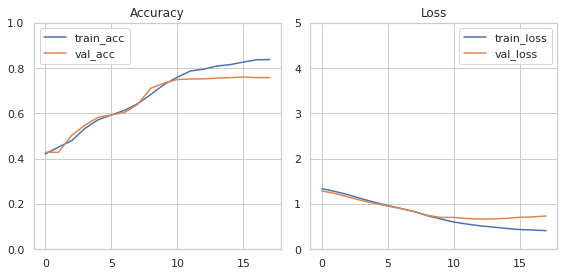

In [22]:
fig, ax = plt.subplots(1, 2, figsize = (8,4))

ax[0].plot(hist.history['acc'], label = 'train_acc')
ax[0].plot(hist.history['val_acc'], label = 'val_acc')
ax[0].set_title('Accuracy')
ax[0].legend()
ax[0].set_ylim(0, 1)

ax[1].plot(hist.history['loss'], label = 'train_loss')
ax[1].plot(hist.history['val_loss'], label = 'val_loss')
ax[1].legend()
ax[1].set_title('Loss')
#ax[1].set_ylim([0,max(hist.history['loss'] + hist.history['val_loss'])])
ax[1].set_ylim([0,5])

fig.tight_layout()
plt.show()

In [23]:
from sklearn.metrics import confusion_matrix

# model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Data Science Trainee JSC/model.h5')

# Melakukan prediksi pada data uji
y_pred = model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)  # Mengubah hasil prediksi menjadi label kelas

# Mengumpulkan label sebenarnya dari data uji
y_true = np.argmax(y_test, axis=1)

# Menghitung confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

62/62 [==============================] - 2s 21ms/step
[[352  50  55  39]
 [ 21 252   1  83]
 [ 57   6 162  40]
 [ 29  71  19 717]]


Index(['HS_Abusive', 'HS_NotAbusive', 'NotHS_Abusive', 'NotHS_NotAbusive'], dtype='object')


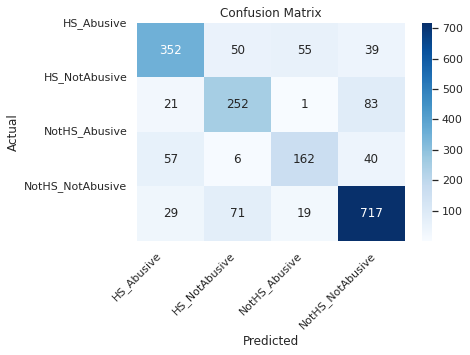

In [37]:
print(labels_list)

sns.heatmap(cm, annot=True, cmap='Blues', fmt='.0f')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.xticks(range(4), labels_list, rotation=45)
plt.yticks(range(4), labels_list, rotation=0)
plt.show()

In [38]:
from sklearn.metrics import classification_report, accuracy_score

print(classification_report(y_true, y_pred))

print(labels_list)

print(accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.77      0.71      0.74       496
           1       0.66      0.71      0.68       357
           2       0.68      0.61      0.65       265
           3       0.82      0.86      0.84       836

    accuracy                           0.76      1954
   macro avg       0.73      0.72      0.73      1954
weighted avg       0.76      0.76      0.76      1954

Index(['HS_Abusive', 'HS_NotAbusive', 'NotHS_Abusive', 'NotHS_NotAbusive'], dtype='object')
0.7589559877175026


## Saved Model

In [27]:
!pip install tensorflowjs

model.save("/content/drive/MyDrive/Colab Notebooks/Data Science Trainee JSC/model.h5")

!tensorflowjs_converter --input_format=keras model.h5 tfjs_model

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.1/85.1 KB 3.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.8/108.8 KB 5.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 63.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 KB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 585.9/585.9 MB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.8/77.8 KB 8.4 MB/s eta 0:00:00
INFO: pip is looking at multiple versions of tensorflow-decision-forests to determine which version is compatible with other requirements. This could take a while.
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 72.9 MB/s eta 0:00:00
  Attempting uninstall: tensorflow-hub
    Found existing installation: tensorflow-hub 0.13.0
    Uninstalling tensorflow-hub-0.13.0:
      Successfully uninstalled tensorfl

# Let's Play

## Package Prepraration

In [29]:
!pip install Sastrawi

import string
import re
import pickle

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
nltk.download('stopwords')
nltk.download('punkt')

import numpy as np
import pandas as pd

import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences

alay_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Data Science Trainee JSC/new_kamusalay.csv', 
                        encoding = 'latin-1', 
                        header = None)

alay_df.rename(columns={0: 'original', 
                        1: 'replacement'},
               inplace = True)

alay_dict_map = dict(zip(alay_df['original'], alay_df['replacement']))

def normalize_alay(text):
  return ' '.join([alay_dict_map[word] if word in alay_dict_map else word for word in text.split(' ')])

def convert_lower_case(text):
  return text.lower()

def remove_stop_words(text):
  stop_words = stopwords.words('indonesian')
  words = word_tokenize(str(text))
  new_text = ""
  for w in words:
    if w not in stop_words and len(w) > 1:
      new_text = new_text + " " + w
  return new_text

def remove_unnecessary_char(text):
  text = re.sub('\n',' ',text) # Remove every '\n'
  text = re.sub('rt',' ',text) # Remove every retweet symbol
  text = re.sub('user',' ',text) # Remove every username
  text = re.sub('((www\.[^\s]+)|(https?://[^\s]+)|(http?://[^\s]+))',' ',text) # Remove every URL
  text = re.sub('  +', ' ', text) # Remove extra spaces
  
  text = re.sub('x9f', ' ', text)
  text = re.sub('x98', ' ', text)
  text = re.sub('xf0', ' ', text)

  text = re.sub(' ya ', ' ', text)
  text = re.sub('x82', ' ', text)
  text = re.sub('uniform', ' ', text)
  text = re.sub('resource', ' ', text)

  text = re.sub('xe2', ' ', text)
  text = re.sub('x80', ' ', text)
  text = re.sub('x91', ' ', text)
  text = re.sub('x8c', ' ', text)

  text = re.sub('locator', ' ', text)
  return text

def remove_punctuation(text):
  symbols = string.punctuation
  for i in range(len(symbols)):
    text = text.replace(symbols[i], ' ')
    text = text.replace("  ", " ")
  text = text.replace(',', '')
  return text

from Sastrawi.Stemmer.StemmerFactory import StemmerFactory

def stemming(text):
  factory = StemmerFactory()
  stemmer = factory.create_stemmer()
  
  tokens = word_tokenize(str(text))
  new_text = ""
  for w in tokens:
    new_text = new_text + " " + stemmer.stem(w)
  return new_text

counter = 0

def preprocess(text, verbose=0):
  global counter

  text = convert_lower_case(text)
  text = remove_unnecessary_char(text)
  text = remove_punctuation(text)
  text = remove_stop_words(text)
  text = normalize_alay(text)
  # text = stemming(text)
  text = remove_stop_words(text)
  text = remove_punctuation(text)

  counter += 1
  if (counter % 10 == 0) and (verbose == 1):
    print(f"\r{counter}", end="")
  return text

with open('/content/drive/MyDrive/Colab Notebooks/Data Science Trainee JSC/tokenizer.pickle',
          'rb') as handle:
    tokenizer = pickle.load(handle)

model = tf.keras.models.load_model('/content/drive/MyDrive/Colab Notebooks/Data Science Trainee JSC/model.h5')

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


## Write a tweet

In [31]:
whats_happening = 'ANYS BONEKA AMERIKA JADI KHILAFAH BUATAN AMERICA PAHAM DRUN !! BUKAN KHILAFAH AJARAN ISLAM' #@param {type: 'string'}

preprocess_tweet = preprocess(whats_happening, verbose=0)

seq_tweet = tokenizer.texts_to_sequences([preprocess_tweet])

the_tweet = pad_sequences(seq_tweet, padding='post',
                          maxlen=1000, truncating='post')

prediction = model.predict(the_tweet, verbose=0)

classes = np.argmax(prediction, axis = 1)

dict_classes = {
    0: 'VERY NEGATIVE. Hate Speech and Abusive Tweet',
    1: 'NEGATIVE. Hate Speech but NOT Abusive Tweet',
    2: 'NETRAL. NOT Hate Speech but Abusive Tweet',
    3: 'POSITIVE. NOT Hate Speech and NOT Abusive Tweet'
}

print('\n\"' + whats_happening + '\"\n')
print("This tweet is:\n   ", dict_classes[classes[0]])


"ANYS BONEKA AMERIKA JADI KHILAFAH BUATAN AMERICA PAHAM DRUN !! BUKAN KHILAFAH AJARAN ISLAM"

This tweet is:
    VERY NEGATIVE. Hate Speech and Abusive Tweet
